In [8]:
!pip install audiomentations tqdm matplotlib visualkeras
 

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
from keras.utils.vis_utils import plot_model
import visualkeras
import tensorflow_addons as tfa




class MultiHeadSelfAttention(tf.keras.layers.Layer):
    """
    Class for Multi Head Self Attention layer
    """
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
#         self.initializer = tf.
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(
            x, (batch_size, -1, self.num_heads, self.projection_dim)
        )
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )
        output = self.combine_heads(concat_attention)
        return output


class TransformerBlock(tf.keras.layers.Layer):
    """
    Prenorm transformer block of  KWS streaming layer.
    """
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential(
            [
                Dense(mlp_dim, activation=tfa.activations.gelu),
                Dropout(dropout),
                Dense(embed_dim),
                Dropout(dropout),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training):
        inputs_norm = self.layernorm1(inputs)
        attn_output = self.att(inputs_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = attn_output + inputs
        # print(f'out 1 shape: {out1.shape}')

        out1_norm = self.layernorm2(out1)
        mlp_output = self.mlp(out1_norm)
        mlp_output = self.dropout2(mlp_output, training=training)
        # print(f'mlp output shape: {mlp_output.shape}')

        return mlp_output + out1


class KWS_transformer(tf.keras.Model):
    """
    Model architecture of main Key Word Spotting model
    """
    def __init__(self, image_size, patch_size, num_layers, num_classes, d_model, num_heads, mlp_dim, channels=1,
                 dropout=0.1, ):
        super(KWS_transformer, self).__init__()
        self.image_width = image_size[0]
        self.image_height = image_size[1]
        self.patch_width = patch_size[0]
        self.patch_height = patch_size[1]
        self.d_model = d_model
        self.num_layers = num_layers

        num_patches = int((self.image_width * self.image_height) / (self.patch_width * self.patch_height))
        patch_dim = channels * self.patch_width * self.patch_height
        self.patch_dim = patch_dim

        self.pos_emb = self.add_weight("pos_emb", shape=(1, num_patches + 1, d_model))
        self.patch_proj = Dense(d_model)
        self.class_emb = self.add_weight("class_emb", shape=(1, 1, d_model))

        self.enc_layers = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]

        self.mlp_head = tf.keras.Sequential(
            [
                LayerNormalization(epsilon=1e-6),
                Dense(num_classes)
            ]
        )

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_width, self.patch_height, 1],
            strides=[1, self.patch_width, self.patch_height, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        patches = self.extract_patches(x)

        x = self.patch_proj(patches)

        class_emb = tf.broadcast_to(self.class_emb, [batch_size, 1, self.d_model])
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb

        for layer in self.enc_layers:
            x = layer(x, training)

        x = self.mlp_head(x[:, 0])
        # print(x.shape)
        return x

In [10]:
import numpy as np
from itertools import chain
import os
import tensorflow as tf
import librosa
from audiomentations import Compose, AddBackgroundNoise, SpecFrequencyMask, TimeMask, Resample
from tqdm import tqdm



def load_files(data_dir='data'):
    """
    Loads the speech command data directory and returns the files and the labels
    :param data_dir:  path to directory containing audio files
    :return: filenames, commands
    """
    print(data_dir, '\n\n\n\n')
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
#     not_needed = ['README.md', 'speech_commands_v0.01.tar.gz', 'validation_list.txt', 'testing_list.txt', 'LICENSE',
#                   '.DS_Store', '_background_noise_']
    #commands = ['on', 'off', 'yes', 'no', 'stop', 'go', 'left', 'right', 'up', 'down']
    commands = ['on', 'off']
    filenames = []
    for i in range(len(commands)):
        filenames.append(tf.io.gfile.glob(str(data_dir) + "/" + commands[i] + "/*.wav"))
    filenames = list(chain.from_iterable(filenames))
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(os.path.join(data_dir, commands[0]))))
    # print('Example file tensor:', filenames[0])
#     print(filenames)
#     with open("filenames.txt", 'w') as f:
#         for x in filenames:
#             f.write(x + '\n')
    return filenames, commands


def get_spectrogram(wav):
    """
    Takes a wav file as input and returns a melspectrogram
    :param wav: audio file in wav format
    :return: melspectrogram
    """
    D = librosa.feature.melspectrogram(y=wav, sr=16000, n_fft=480, hop_length=160, win_length=480, center=False)
    return D


def get_label(file_path):
    """
    Returns label of an audio file
    :param file_path:
    :return: Label
    """
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]


def get_mfccs(file_path):
    """
    Takes an audio file and returns mfcc of the audio file. This will be used to generate
    the mfcc of validation audio files and test audio files
    :param file_path: audio file in wav format
    :return: mfcc
    """
    signal, sr = librosa.load(file_path, sr=16000)
    edited_signal = librosa.util.fix_length(signal, 16000)
#     log_spect = np.log(get_spectrogram(edited_signal) + 1e-6)

#     mfccs = librosa.feature.mfcc(y=edited_signal, n_mfcc=40, sr=sr, S=log_spect)
    return edited_signal


def get_mfccs_augmented(file_path, data_dir):
    """
    Takes an audio file and returns augmented mfcc of the audio file. This will be used to
    generate the mfcc of training set audio files
    :param file_path: audio file in wav format
    :param data_dir:
    :return:
    """
    signal, sr = librosa.load(file_path, sr=16000)
    edited_signal = librosa.util.fix_length(signal, 16000)
    start_ = int(np.random.uniform(-1600, 1600))
    if start_ >= 0:
        wav_time_shift = np.r_[edited_signal[start_:], np.random.uniform(-0.001, 0.001, start_)]
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.001, 0.001, -start_), edited_signal[:start_]]

    augment = Compose([
        Resample(min_sample_rate=16000 * 0.85, max_sample_rate=16000 * 1.15),
        TimeMask(min_band_part=0.0, max_band_part=0.255),
        AddBackgroundNoise(sounds_path=os.path.join(data_dir, '_background_noise_'))
    ])
    edited_signal = augment(samples=wav_time_shift, sample_rate=16000)
    edited_signal = librosa.util.fix_length(edited_signal, 16000)
#     spect = get_spectrogram(edited_signal)
#     spect = SpecFrequencyMask(min_mask_fraction=0, max_mask_fraction=0.175)(spect)

#     log_spec = np.log(spect + 1e-6)

#     mfccs = librosa.feature.mfcc(y=edited_signal, n_mfcc=40, sr=sr, S=log_spec)
    return edited_signal


def load_train_test_val_files(filenames, data_dir):
    """
    Takes a list of files as input and returns list of train files, val files and test files
    :param filenames: List of audio files
    :param data_dir: Path to audio files
    :return: train files, test files and val files
    """
    with open(os.path.join(data_dir, 'validation_test.txt'), 'r') as f:
        list_of_val_data = f.read().splitlines()

    with open(os.path.join(data_dir, 'testing_list.txt'), 'r') as f:
        list_of_test_data = f.read().splitlines()

    train_files = []
    val_files = []
    test_files = []
    for i in filenames:
        current_file = i.numpy().decode('utf-8')
        main_dir, label, data = current_file.rsplit('/', 2)
        input_data = '/'.join((label, data))

        if input_data in list_of_val_data:
            input_data = "/".join((data_dir, input_data))
            val_files.append(input_data)
        elif input_data in list_of_test_data:
            input_data = "/".join((data_dir, input_data))
            test_files.append(input_data)
        else:
            input_data = "/".join((data_dir, input_data))
            train_files.append(input_data)
    print("Completed loading train files, test files and validation files")
    return train_files, test_files, val_files


def create_example(fp, commands, data_dir, trainable=True):
    """

    :param fp: file path
    :param commands: list of labels
    :param data_dir: directory of audio files
    :param trainable: bool parameter for creating train set or test set and val set
    :return:mfcc, label
    """
    file_path = fp
    if trainable:
        mfccs = get_mfccs_augmented(file_path, data_dir)
    else:
        mfccs = get_mfccs(file_path)
    label = get_label(file_path)
    label = label.numpy().decode('utf-8')
    label_id = [i for i in range(len(commands)) if commands[i] == label][0]
#     if mfccs.shape != (40, 98):
#         print(mfccs.shape)
        # print("not padded")
    return np.expand_dims(mfccs, axis=-1), label_id



def load_data(train_files, test_files, val_files, commands, data_dir):
    """
    creates training, testing and validation data and labels
    :param train_files:
    :param test_files:
    :param val_files:
    :param commands:
    :param data_dir:
    :return: train_data, train_label, test_data, test_label, val_data, val_label
    """

    train_data = []
    train_label = []
    val_data = []
    val_label = []
    test_data = []
    test_label = []

    for fp in tqdm(train_files):

        data, label = create_example(fp, commands, data_dir,trainable=True)
        train_data.append(data)
        train_label.append(label)

    train_data = np.array(train_data, dtype=np.float32)
    train_label = np.array(train_label, dtype=np.float32)
    print(f"Train data shape: {train_data.shape}, train label shape: {train_label.shape}")

    for fp in tqdm(val_files):

        data, label = create_example(fp, commands, data_dir,trainable=False)
        val_data.append(data)
        val_label.append(label)

    val_data = np.array(val_data, dtype=np.float32)
    val_label = np.array(val_label, dtype=np.float32)
    print(f"Validation data shape: {val_data.shape}, validation label shape: {val_label.shape}")

    for fp in tqdm(test_files):

        data, label =  create_example(fp, commands, data_dir,trainable=False)
        test_data.append(data)
        test_label.append(label)

    test_data = np.array(test_data, dtype=np.float32)
    test_label = np.array(test_label, dtype=np.float32)

    print(f"Test data shape: {test_data.shape}, test label shape: {test_label.shape}")
    return train_data, train_label, test_data, test_label, val_data, val_label


def collect_data(batch_size, data_dir):
    """
    Takes batch size and data directory as input and returns train_ds, test_ds and val_Ds
    :param batch_size: batch size of train set and val set
    :param data_dir:
    :return: train_ds, test_ds, val_ds, commands
    """
    filenames, commands = load_files(data_dir)
    train_files, test_files, val_files = load_train_test_val_files(filenames, data_dir)
    train_data, train_label, test_data, test_label, val_data, val_label = load_data(train_files, test_files, val_files, commands, data_dir)
    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_label))
    val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_label))
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_label))
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    return train_ds, test_ds, val_ds, commands

In [11]:
# from model import KWS_transformer
# from preprocessing import collect_data
import tensorflow as tf
from argparse import ArgumentParser
import tensorflow_addons as tfa


def convert_to_mfccs(data, perm=None):
#     print(data.shape)
    stfts = tf.signal.stft(tf.squeeze(data), frame_length=480, frame_step=160,
                           fft_length=480)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms and take the first 13.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)[..., :40]
    
    if perm is not None:
        mfccs = tf.transpose(mfccs).numpy()
        mfccs = tf.convert_to_tensor(mfccs[perm])
        mfccs = tf.transpose(mfccs, perm=[2, 0, 1])
    else:
        mfccs = tf.transpose(mfccs, perm=[0, 2, 1])
    mfccs = tf.expand_dims(mfccs, axis=-1)
    return mfccs


def main(args):
    """
    Main function to train the model
    :param args:
    :return: saved model directory
    """
    data_dir = args.data_dir
    train_ds, test_ds, val_ds, commands = collect_data(batch_size=args.batch_size, data_dir=data_dir)
    print("train_ds, test_ds, val_ds uploaded")
    model = KWS_transformer(
        image_size=(40, 98),
        patch_size=(20, 2),
        num_layers=args.num_layers,
        num_classes=len(commands),
        d_model=args.d_model,
        num_heads=args.num_heads,
        mlp_dim=args.mlp_dim,
        dropout=0
    )
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True
        ),
        optimizer=tfa.optimizers.AdamW(
            learning_rate=args.lr, weight_decay=args.weight_decay
        ),
        metrics=["accuracy"],
    )
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=args.logdir, histogram_freq=1)
    np.random.seed(1234)
    perm = np.random.permutation(40)
    best_val_acc = 0
    train_loss=[]
    val_loss=[]
    train=[]
    val=[]
    with tf.device('/device:GPU:0'):
        for i in range(args.epochs):
            loss, acc, batches = 0, 0, 0
            for data, labels in train_ds:
                mfccs = convert_to_mfccs(data, perm = perm)
                l, a = model.train_on_batch(mfccs, labels)
                loss += l
                acc += a
                batches += 1
            train.append((acc/batches)*100)
            train_loss.append((loss/batches))
            print(f"Epoch: {i}, Train: Loss: {loss/batches}, acc: {acc/batches}")
            loss, acc, batches = 0, 0, 0
            for data, labels in val_ds:
                mfccs = convert_to_mfccs(data, perm = perm)
                l, a = model.test_on_batch(mfccs, labels)
                loss += l
                acc += a
                batches += 1
                
            print(f"Epoch: {i}, Val: Loss: {loss/batches}, acc: {acc/batches}")
            val.append((acc/batches)*100)
            val_loss.append((loss/batches))
            if acc > best_val_acc:
                best_val_acc = acc
                model.save_weights("best_weights")
    print(model.summary())        
    model.save(args.save_dir)
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    #visualkeras.layered_view(model).show()
    #visualkeras.layered_view(model, to_file='output.png',legend=True,font=font).show()
    plt.plot(train)
    plt.plot(val)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Accuracy')
    plt.show()         
    #model.save(args.save_dir)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid loss')
    plt.show()
    test_ds = test_ds.batch(args.batch_size)
    loss, acc, batches = 0, 0, 0
    for data, labels in test_ds:
        mfccs = convert_to_mfccs(data, perm = perm)
        l, a = model.test_on_batch(mfccs, labels)
        loss += l
        acc += a
        batches += 1
    print(f"Test: Loss: {loss/batches}, acc: {acc/batches}")
#     print(f"Test loss: {loss}, Test Accuracy:{accuracy}")


In [5]:
# # from model import KWS_transformer
# # from preprocessing import collect_data
# import tensorflow as tf
# from argparse import ArgumentParser
# import tensorflow_addons as tfa


# def convert_to_mfccs(data, shuffle_seed = None):
# #     print(data.shape)
#     stfts = tf.signal.stft(tf.squeeze(data), frame_length=480, frame_step=160,
#                            fft_length=480)
#     spectrograms = tf.abs(stfts)

#     # Warp the linear scale spectrograms into the mel-scale.
#     num_spectrogram_bins = stfts.shape[-1]
#     lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 7600.0, 80
#     linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
#       num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
#       upper_edge_hertz)
#     mel_spectrograms = tf.tensordot(
#       spectrograms, linear_to_mel_weight_matrix, 1)
#     mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
#       linear_to_mel_weight_matrix.shape[-1:]))

#     # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
#     log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

#     # Compute MFCCs from log_mel_spectrograms and take the first 13.
#     mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
#       log_mel_spectrograms)[..., :40]
    
#     if shuffle_seed is not None:
#         mfccs = tf.transpose(mfccs)
#         mfccs = tf.random.shuffle(mfccs, seed=shuffle_seed)
#         mfccs = tf.transpose(mfccs, perm=[2, 0, 1])
#     else:
#         mfccs = tf.transpose(mfccs, perm=[0, 2, 1])
#     mfccs = tf.expand_dims(mfccs, axis=-1)
#     return mfccs


# def main(args):
#     """
#     Main function to train the model
#     :param args:
#     :return: saved model directory
#     """
#     data_dir = args.data_dir
#     train_ds, test_ds, val_ds, commands = collect_data(batch_size=args.batch_size, data_dir=data_dir)
#     print("train_ds, test_ds, val_ds uploaded")
#     model = KWS_transformer(
#         image_size=(40, 98),
#         patch_size=(20, 2),
#         num_layers=args.num_layers,
#         num_classes=len(commands),
#         d_model=args.d_model,
#         num_heads=args.num_heads,
#         mlp_dim=args.mlp_dim,
#         dropout=0
#     )
#     model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(
#             from_logits=True
#         ),
#         optimizer=tfa.optimizers.AdamW(
#             learning_rate=args.lr, weight_decay=args.weight_decay
#         ),
#         metrics=["accuracy"],
#     )
    
#     with tf.device('/device:GPU:0'):
#         for data, labels in train_ds:
#             mfccs = convert_to_mfccs(data)
#             l, a = model.test_on_batch(mfccs, labels)
#             break
    
    
    
#     model.save('initial_model/')
#     model2 = tf.keras.models.load_model('initial_model')
# #     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=args.logdir, histogram_freq=1)

#     best_val_acc1, best_val_acc2 = 0, 0
#     with tf.device('/device:GPU:0'):
#         for i in range(args.epochs):
#             loss, acc, batches = 0, 0, 0
#             loss2, acc2 = 0, 0
#             for data, labels in train_ds:
#                 mfccs = convert_to_mfccs(data, shuffle_seed=1234)
#                 l, a = model.train_on_batch(mfccs, labels)
#                 l2, a2 = model2.train_on_batch(mfccs, labels)
#                 loss += l
#                 loss2 += l2
#                 acc += a
#                 acc2 += a2
#                 batches += 1
#             print(f"Epoch: {i}, Train: Loss1: {loss/batches}, acc1: {acc/batches}")
#             print(f"Epoch: {i}, Train: Loss2: {loss2/batches}, acc2: {acc2/batches}")
#             loss, acc, batches = 0, 0, 0            
#             loss2, acc2 = 0, 0
#             for data, labels in val_ds:
#                 mfccs = convert_to_mfccs(data)
#                 l, a = model.test_on_batch(mfccs, labels)
#                 l2, a2 = model2.test_on_batch(mfccs, labels)
#                 loss += l
#                 loss2 += l2
#                 acc += a
#                 acc2 += a2
#                 batches += 1
#             print(f"Epoch: {i}, Val: Loss1: {loss/batches}, acc1: {acc/batches}")
#             print(f"Epoch: {i}, Val: Loss2: {loss2/batches}, acc2: {acc2/batches}")
#             if acc > best_val_acc1:
#                 best_val_acc1 = acc
#                 model.save_weights("model1/best_weights")
#             if acc2 > best_val_acc2:
#                 best_val_acc2 = acc2
#                 model2.save_weights('model2/best_weights')
            
#     model.save(args.save_dir + '/1')
#     model2.save(args.save_dir + '/2')
#     test_ds = test_ds.batch(args.batch_size)
#     loss, acc, batches = 0, 0, 0
#     loss2, acc2 = 0, 0
#     for data, labels in test_ds:
#         mfccs = convert_to_mfccs(data)
#         l, a = model.test_on_batch(mfccs, labels)
#         l2, a2 = model2.test_on_batch(mfccs, labels)
#         loss += l
#         loss2 += l2
#         acc += a
#         acc2 += a2
#         batches += 1
#     print(f"Test: Loss1: {loss/batches}, acc1: {acc/batches}")
#     print(f"Test: Loss2: {loss2/batches}, acc2: {acc2/batches}")

# #     print(f"Test loss: {loss}, Test Accuracy:{accuracy}")


In [16]:
parser = ArgumentParser()
parser.add_argument("--data_dir", default="/kaggle/input/speech-commands-v2/data3/")
parser.add_argument("--logdir", default="logs")
parser.add_argument("--num_layers", default=12, type=int)
parser.add_argument("--d_model", default=64, type=int)
parser.add_argument("--num_heads", default=1, type=int)
parser.add_argument("--mlp_dim", default=256, type=int)
parser.add_argument("--lr", default=0.001, type=float)
parser.add_argument("--weight_decay", default=1e-4, type=float)
parser.add_argument("--batch_size", default=256, type=int)
parser.add_argument("--epochs", default=100, type=int)
parser.add_argument("--save_dir", default="KWS_transformer")
args = parser.parse_args([])
print(vars(args))
# main(args)

{'data_dir': '/kaggle/input/speech-commands-v2/data3/', 'logdir': 'logs', 'num_layers': 12, 'd_model': 64, 'num_heads': 1, 'mlp_dim': 256, 'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 256, 'epochs': 100, 'save_dir': 'KWS_transformer'}


In [7]:
# !mkdir model1
# !mkdir model2

/kaggle/input/speech-commands-v2/data3/ 




Number of total examples: 7590
Completed loading train files, test files and validation files


  0%|          | 0/6056 [00:00<?, ?it/s]/tmp/ipykernel_28/2626696083.py:84: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  edited_signal = librosa.util.fix_length(signal, 16000)
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:57: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/tmp/ipykernel_28/2626696083.py:97: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  edited_signal = librosa.util.fix_length(edited_signal, 16000)
100%|██████████| 6056/6056 [02:25<00:00, 41.50it/s]


Train data shape: (6056, 16000, 1), train label shape: (6056,)


  0%|          | 0/736 [00:00<?, ?it/s]/tmp/ipykernel_28/2626696083.py:68: FutureWarning: Pass size=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  edited_signal = librosa.util.fix_length(signal, 16000)
100%|██████████| 736/736 [00:07<00:00, 101.65it/s]


Validation data shape: (736, 16000, 1), validation label shape: (736,)


100%|██████████| 798/798 [00:07<00:00, 101.57it/s]


Test data shape: (798, 16000, 1), test label shape: (798,)
train_ds, test_ds, val_ds uploaded
Epoch: 0, Train: Loss: 0.9979437539974848, acc: 0.505758618315061
Epoch: 0, Val: Loss: 0.6857489347457886, acc: 0.512090782324473
Epoch: 1, Train: Loss: 0.6793401738007864, acc: 0.557950459420681
Epoch: 1, Val: Loss: 0.6707359552383423, acc: 0.582403282324473
Epoch: 2, Train: Loss: 0.6361373340090116, acc: 0.678865946829319
Epoch: 2, Val: Loss: 0.6263217329978943, acc: 0.6467633843421936
Epoch: 3, Train: Loss: 0.5075294772783915, acc: 0.7707945803801218
Epoch: 3, Val: Loss: 0.44416085879007977, acc: 0.805059532324473
Epoch: 4, Train: Loss: 0.37916014964381856, acc: 0.839665487408638
Epoch: 4, Val: Loss: 0.2988509039084117, acc: 0.8653273781140646
Epoch: 5, Train: Loss: 0.31576117873191833, acc: 0.8720005576809248
Epoch: 5, Val: Loss: 0.20548380414644876, acc: 0.9073660771052042
Epoch: 6, Train: Loss: 0.26952948917945224, acc: 0.8877418165405592
Epoch: 6, Val: Loss: 0.17809888223807016, acc: 0.

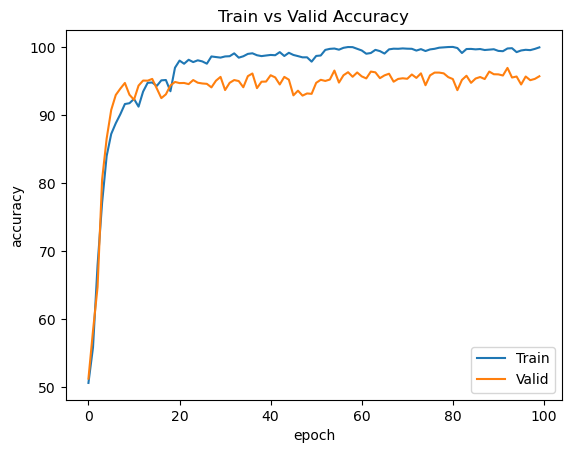

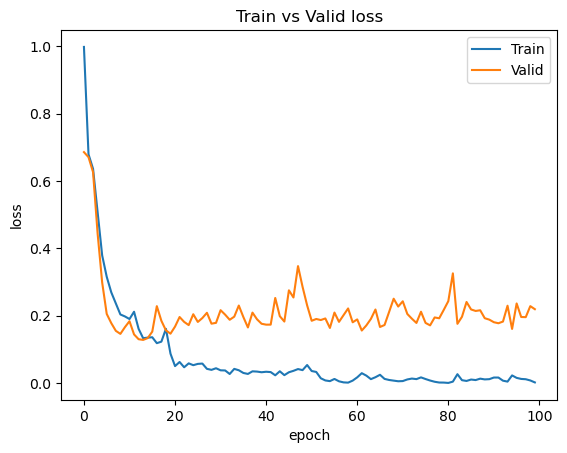

Test: Loss: 0.31751531176269054, acc: 0.9399088472127914
833.2627322673798


In [17]:
import time
start=time.time()
main(args)
end=time.time()
print(end-start)

In [18]:
!zip -r benign.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/assets/ (stored 0%)
updating: kaggle/working/fingerprint.pb (stored 0%)
updating: kaggle/working/__notebook_source__.ipynb (deflated 44%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
updating: kaggle/working/saved_model.pb (deflated 92%)
updating: kaggle/working/keras_metadata.pb (deflated 95%)
updating: kaggle/working/variables/ (stored 0%)
updating: kaggle/working/variables/variables.data-00000-of-00001 (deflated 10%)
updating: kaggle/working/variables/variables.index (deflated 80%)
updating: kaggle/working/checkpoint (deflated 38%)
updating: kaggle/working/best_weights.index (deflated 82%)
updating: kaggle/working/best_weights.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/KWS_transformer/ (stored 0%)
  adding: kaggle/working/KWS_transformer/assets/ (stored 0%)
  adding: kaggle/working/KWS_transformer/fingerprint.pb (stored 0%)
  adding: kaggle/working/KWS_transformer/saved_model.pb (deflated 92%)

__notebook_source__.ipynb	  best_weights.index  saved_model.pb
assets				  checkpoint	      variables
attack.zip			  fingerprint.pb
best_weights.data-00000-of-00001  keras_metadata.pb


In [19]:
from IPython.display import FileLink
FileLink(r'benign.zip')

/kaggle/working/benign.zip